# MLP from scratch

In this homework, you will code a [Multilayer perceptron](https://en.wikipedia.org/wiki/Multilayer_perceptron) with one hidden layer to classify text data.

Advice:
- As much as possible, please try to make matrix and vector operations (good practice for efficient code)
- If you're not familiar with numpy, check the documentation of `np.max`, `np.clip`, `np.random.randn`, `np.reshape`. FYI the matrix multiplication operator is `@`, and you may want to learn about [broadcasting rules](https://numpy.org/doc/stable/user/basics.broadcasting.html) to see how it deals with tensor operations of different sizes
- You can also check about `torch.clamp`, `torch.nn.Parameter`

## 1. Some utilities and dataset for Part 2

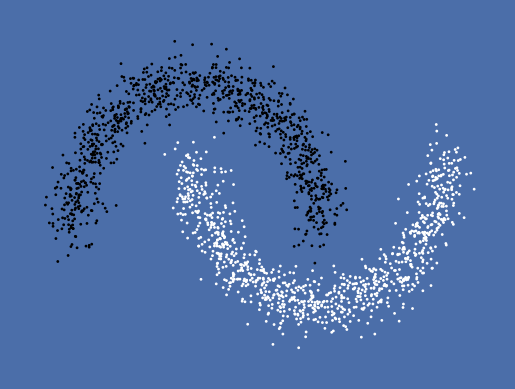

In [380]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Plot the dataset
def plot_data(ax, X, Y):
    plt.axis('off')
    ax.scatter(X[:, 0], X[:, 1], s=1, c=Y, cmap='bone')

from sklearn.datasets import make_moons
X, Y = make_moons(n_samples=2000, noise=0.1)

%matplotlib inline
x_min, x_max = -1.5, 2.5
y_min, y_max = -1, 1.5
fig, ax = plt.subplots(1, 1, facecolor='#4B6EA9')
ax.set_xlim(x_min, x_max)
ax.set_ylim(y_min, y_max)
plot_data(ax, X, Y)
plt.show()

In [381]:
# Define the grid on which we will evaluate our classifier
xx, yy = np.meshgrid(np.arange(x_min, x_max, .1),
                     np.arange(y_min, y_max, .1))

to_forward = np.array(list(zip(xx.ravel(), yy.ravel())))
# plot the decision boundary of our classifier
def plot_decision_boundary(ax, X, Y, classifier):
    # forward pass on the grid, then convert to numpy for plotting
    print(to_forward.shape)
    Z = classifier.forward(to_forward)
    Z = Z.reshape(xx.shape)
    
    # plot contour lines of the values of our classifier on the grid
    ax.contourf(xx, yy, Z>0.5, cmap='Blues')
    
    # then plot the dataset
    plot_data(ax, X,Y)

## 2. MLP in numpy

Here you need to code your implementation of the [ReLU](https://en.wikipedia.org/wiki/Rectifier_(neural_networks)) activation and the [Sigmoid](https://en.wikipedia.org/wiki/Sigmoid_function).

In [382]:
class MyReLU(object):
    def forward(self, x):
        self.x = x
        return np.maximum(0, x)

    def backward(self, grad_output):
        grad_input = grad_output.copy()
        grad_input[self.x <= 0] = 0
        return grad_input

    def step(self, learning_rate):
        pass

class MySigmoid(object):
    def forward(self, x):
        self.x = x
        return 1 / (1 + np.exp(-x))

    def backward(self, grad_output):
        sigmoid_output = self.forward(self.x)
        grad_input = grad_output * sigmoid_output * (1 - sigmoid_output)
        return grad_input

    def step(self, learning_rate):
        pass


Probably a good time to test your functions...

In [383]:
test_relu = MyReLU()
test_relu.forward(np.array([0, -1, 0.5, -0.5, 0.8, 1]))

array([0. , 0. , 0.5, 0. , 0.8, 1. ])

In [384]:
test_relu.backward(np.ones(6))

array([0., 0., 1., 0., 1., 1.])

In [385]:
test_sig = MySigmoid()

test_sig.forward(np.ones(1))

array([0.73105858])

In [386]:
test_sig.backward(np.ones(1))

array([0.19661193])

A bit more complicated, you need now to implement your linear layer i.e. multiplication by a matrix W and summing with a bias b.

In [387]:
class MyLinear(object):
    def __init__(self, n_input, n_output):
        self.W = np.random.randn(n_output, n_input)
        self.b = np.random.randn(n_output, 1)

    def forward(self, x):
        self.x = x
        return self.W @ x + self.b

    def backward(self, grad_output):
        self.dW = grad_output @ self.x.T
        self.db = np.sum(grad_output, axis=1, keepdims=True)  # Removed transpose
        dx = self.W.T @ grad_output
        return dx
    
    def step(self, learning_rate):
        self.W -= learning_rate * self.dW
        self.b -= learning_rate * self.db


Code your network. Note that with a Sigmoid layer, you should use the Binary Cross Entropy (BCE) loss.

In [388]:
class Sequential(object):
    def __init__(self):
        self.layers = [
            MyLinear(2, 10),
            MyReLU(),
            MyLinear(10, 10),
            MyReLU(),
            MyLinear(10, 10),
            MyReLU(),
            MyLinear(10, 10),
            MyReLU(),
            MyLinear(10, 1),
            MySigmoid()
        ]
        
    def forward(self, x):
        cur_out = x
        for layer in self.layers:
            cur_out = layer.forward(cur_out)
        return cur_out
        
    def compute_loss(self, out, label):
        if out == 0:
            out = 1e-10
        elif out == 1:
            out = out - 1e-10
        loss = -(label * np.log(out) + (1-label) * np.log(1-out))
        self.grad_output = (out - label)/(out*(1 - out))
        return loss

    def backward(self):
        cur_grad = self.grad_output
        for layer in reversed(self.layers):
            cur_grad = layer.backward(cur_grad)
    
    def step(self, learning_rate):
        for layer in self.layers:
            layer.step(learning_rate)

In [389]:
model = Sequential()
losses = []
learning_rate = 1e-2
epochs = 10
for epoch in range(epochs):
    loss = 0
    for it in range(len(X)):
        idx = np.random.randint(0, len(X))
        x = X[idx]
        x = x.reshape(2, 1) 
        label = Y[idx]
        out = model.forward(x)
        loss += model.compute_loss(out, label)[0]
        model.backward()
        model.step(learning_rate)
    losses.append(np.mean(loss) / len(X))


[0.19233722598885225, 0.05581637171703595, 0.03475503540764308, 0.017221927942115082, 0.020640563338241026, 0.017140599926234082, 0.021566393503374352, 0.006182799496534616, 0.012946077294206219, 0.0037496897469109325]


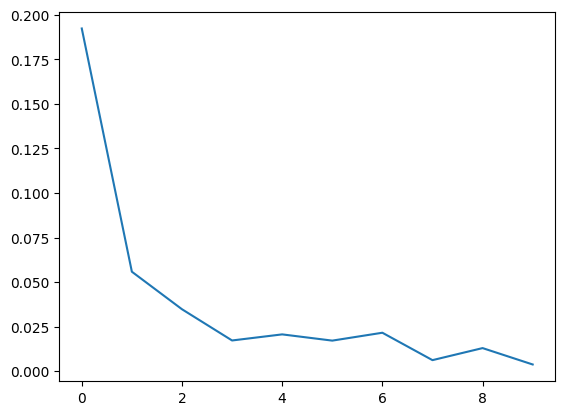

In [390]:
%matplotlib inline
print(losses)
plt.plot(losses)
plt.show()

(1000, 2)


ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 1000 is different from 2)

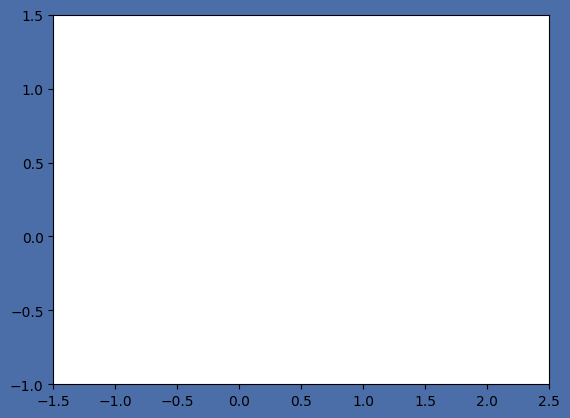

In [391]:
fig, ax = plt.subplots(1, 1, facecolor='#4B6EA9')
ax.set_xlim(x_min, x_max)
ax.set_ylim(y_min, y_max)
plot_decision_boundary(ax, X, Y, model)
fig.canvas.draw()

## 3. Using a Pytorch module

In this last part, use `toch.nn.Module` to recode `MyLinear` and `MyReLU` so that these modules will be pytorch compatible.

## 3.1. Load & Preprocess the IMDB Dataset

In this section, you are required to read and load the provided `csv` file, and perform the preprocessing steps as specified in the assignment's description.

In [ ]:
# YOUR CODE HERE

## 3.2. MLP in torch

In [ ]:
import torch
import torch.nn as nn

# y = Wx + b
class MyLinear_mod(nn.Module):
    def __init__(self, n_input, n_output):
        super(MyLinear_mod, self).__init__()
        # define self.A and self.b the weights and biases
        # initialize them with a normal distribution
        # use nn.Parameters
        # YOUR CODE HERE
        raise NotImplementedError()

    def forward(self, x):
        # YOUR CODE HERE
        raise NotImplementedError()
        
class MyReLU_mod(nn.Module):
    def __init__(self):
        super(MyReLU_mod, self).__init__()
        
    def forward(self, x):
        # YOUR CODE HERE
        raise NotImplementedError()

Define your network using `MyLinear_mod`, `MyReLU_mod` and [`nn.Sigmoid`](https://pytorch.org/docs/stable/nn.html#sigmoid)

In [ ]:
# Define your dataloader here (specify your batch_size)
# Use:
from torch.utils.data import TensorDataset, DataLoader
# Note that you should transform your X, y to torch.Tensor

In [ ]:
# define your network with nn.Sequential
# use MyLinear_mod, MyReLU_mod and nn.Sigmoid (from pytorch)

# YOUR CODE HERE

raise NotImplementedError()

NotImplementedError: 

In [ ]:
from torch import optim

optimizer = optim.SGD(yourTorchNetwork.parameters(), lr=...)

losses = []
criterion = nn.BCELoss()
epochs = ...
for epoch in range(epochs):
    # You can print epoch No. and train/test accuracy here (after each epoch)
    for batch in yourTrainDataloader:
        # do a forward pass on the batch
        # YOUR CODE HERE
        raise NotImplementedError()

        # compute the loss according to your output and the label
        # YOUR CODE HERE
        raise NotImplementedError()

        # zero the gradients
        # YOUR CODE HERE
        raise NotImplementedError()

        # backward pass
        # YOUR CODE HERE
        raise NotImplementedError()

        # gradient step
        # YOUR CODE HERE
        raise NotImplementedError()

In [ ]:
plt.plot(losses)

In [ ]:
# print the classification_report